### Introduction

This Jupyter Notebook is dedicated to building a predictive model for movie success. By combining data on movie metadata, character details, and enriched information from TMDb, our goal is to create a robust predictor that can estimate a movie's success based on various factors like genre, actor collaborations, and character traits. This analysis will lay the groundwork for understanding what makes a movie successful, helping to uncover the key elements that contribute to box office performance and critical acclaim. Through data merging, cleaning, and advanced modeling, this Notebook aims to provide valuable insights into the factors driving cinematic success.


This cell imports the necessary libraries and modules that are used throughout the Notebook for data processing, visualization, and machine learning tasks. The key libraries include:

- **pandas and numpy**: Used for data manipulation and numerical operations.
- **matplotlib and seaborn**: Used for creating plots and visualizations.
- **xgboost**: Provides powerful gradient boosting algorithms for building predictive models.
- **sklearn**: Includes tools for data preprocessing, model evaluation, and splitting datasets into training and testing sets.
- **scipy.stats**: Used for statistical operations, such as generating distributions for hyperparameter tuning.

This extensive list of imports suggests a comprehensive data science workflow that covers data handling, model building, and visualization.

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score,KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import uniform, randint
import seaborn as sns
import scipy.stats as stats

In [171]:
import os
print(os.getcwd())
ABS_PATH = '/Users/mohamedhedihidri/Desktop/ada-2024-project-theundocumentedanalysts/data'

/Users/mohamedhedihidri/Desktop/ada-2024-project-theundocumentedanalysts/src/drafts


### Loading Movie and Character Metadata

This cell loads two datasets containing movie metadata and character information using Pandas. The `movie_metadata` dataset provides details about movies such as their IDs, names, release dates, box office revenue, runtime, languages, countries, and genres. The `character_metadata` dataset focuses on character-level details, including names, associated movies, actors' personal information, and unique identifiers.

In [172]:
movie_metadata = pd.read_csv(ABS_PATH+'/MovieSummaries/movie.metadata.tsv', sep='\t', header=None, 
                names=['wikipedia_movie_id', 
                        'freebase_movie_id', 
                        'movie_name', 
                        'movie_release_date', 
                        'movie_box_office_revenue', 
                        'movie_runtime', 
                        'movie_languages', 
                        'movie_countries', 
                        'movie_genres'])


character_metadata = pd.read_csv(ABS_PATH+'/MovieSummaries/character.metadata.tsv', sep='\t', 
                                header=None, 
                                names=['wikipedia_movie_id',
                                'freebase_movie_id',
                                'movie_release_date',
                                'character_name',
                                'actor_date_of_birth',
                                'actor_gender',
                                'actor_height',
                                'actor_ethnicity',
                                'actor_name',
                                'actor_age_at_movie_release',
                                'freebase_character_actor_map_id',
                                'freebase_character_id',
                                'freebase_actor_id'])

### Merging Character and Movie Metadata

This cell merges the `character_metadata` and `movie_metadata` DataFrames on the common column `wikipedia_movie_id` using an inner join. This operation creates a new dataset, `merged_movie_character`, which combines information about both movies and their associated characters. The inner join ensures that only rows with matching `wikipedia_movie_id` values in both DataFrames are retained.

In [173]:
merged_movie_character = pd.merge(character_metadata, movie_metadata, 
                                  left_on='wikipedia_movie_id', 
                                  right_on='wikipedia_movie_id', 
                                  how='inner')

### Dropping Unnecessary Columns

In this cell, several columns are dropped from the `merged_movie_character` DataFrame, including `freebase_character_actor_map_id`, `freebase_character_id`, `freebase_actor_id`, `freebase_movie_id_x`, and `freebase_movie_id_y`. These columns contain identifiers that are not relevant for further analysis. 

In [174]:

#remove the columns freebase_character_actor_map_id freebase_character_id freebase_actor_id  freebase_movie_id_y

merged_movie_character = merged_movie_character.drop(['freebase_character_actor_map_id',
                                                                'freebase_character_id',
                                                                'freebase_actor_id',
                                                                'freebase_movie_id_x',
                                                                'freebase_movie_id_y'], axis=1)


### Loading and Cleaning TMDb Dataset

This cell loads data from a TMDb dataset stored in an Excel file. After loading the data, it applies several preprocessing steps:

1. **Filtering**: The dataset is filtered to retain only movies with a release date on or before `2014-03-28`.

2. **Column Removal**: Various columns such as `ID`, `FILMID`, `BACKDROP_PATH`, `HOMEPAGE`, `IMDB_ID`, `POSTER_PATH`, `ORIGINAL_LANGUAGE`, `ORIGINAL_TITLE`, `OVERVIEW`, `STATUS_`, and `COLLECTIONID` are removed. This step reduces unnecessary data, focusing on relevant attributes.

3. **Merging with Character Data**: The cleaned TMDb dataset is then merged with the `merged_movie_character` DataFrame on the `movie_name` (from `merged_movie_character`) and `TITLE` (from the TMDb dataset) columns using an inner join. This creates a new dataset, `merged_movie_character_tmdb`, which combines movie-specific data from TMDb with previously merged character and movie metadata.


In [175]:
#load tmdb dataset (xlsx file)
tmdb = pd.read_excel(ABS_PATH+'/TMDB_dataset/MOVIE.xlsx')

#remove values where release date is after 2014-03-28
tmdb = tmdb[tmdb['RELEASE_DATE'] <= '2014-03-28']
#remove column ID, FILMID, BACKDROP_PATH, HOMEPAGE, IMDB_ID, ORIGINAL_LANGUAGE, ORIGINAL_TITLE, OVERVIEW,STATUS ,COLLECTIONID,POSTER_PATH
tmdb = tmdb.drop(['ID', 'FILMID', 'BACKDROP_PATH', 'HOMEPAGE', 'IMDB_ID','POSTER_PATH', 'ORIGINAL_LANGUAGE', 'ORIGINAL_TITLE', 'OVERVIEW', 'STATUS_', 'COLLECTIONID'], axis=1)
#join the tmdb dataset with the merged_movie_character_plot dataset on the movie_name column
merged_movie_character_tmdb = pd.merge(merged_movie_character, tmdb, 
                                            left_on='movie_name', 
                                            right_on='TITLE', 
                                            how='inner')


### Handling Missing Budget and Dropping Irrelevant Columns

This cell performs several data cleaning tasks on the `merged_movie_character_tmdb` DataFrame:


1. **Dropping Irrelevant Columns**: It removes the `actor_date_of_birth`, `REVENUE` (since `movie_box_office_revenue` is already present), `TAGLINE`, and `TITLE` columns to streamline the dataset by retaining only necessary features.

2. **Handling Missing Values in Budget**: Rows with missing values and 0s in the `BUDGET` column are dropped to ensure all entries have valid budget data.



In [176]:

#remove actor_date_of_birth, revenue column (since we already have box office revenue),tagline and title
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['actor_date_of_birth','REVENUE','TAGLINE','TITLE'], axis=1)
#remove values where budget is NaN or 0
merged_movie_character_tmdb = merged_movie_character_tmdb[merged_movie_character_tmdb['BUDGET'] > 0]



### Dropping Columns with High Missing Values

This cell removes columns with more than 40% missing values from the `merged_movie_character_tmdb` DataFrame, ensuring that only features with sufficient data are retained for analysis. This step reduces noise and improves data quality.

In [177]:
#remove column with more than 40% missing values
merged_movie_character_tmdb = merged_movie_character_tmdb.dropna(thresh=0.6*len(merged_movie_character_tmdb), axis=1)


### Filling Missing Numeric Values

This cell fills missing values in numeric columns with their median values, ensuring data consistency and robustness against outliers.

In [178]:
#fill missing values in each column with numerical values with the median value of that column
for column in merged_movie_character_tmdb.select_dtypes(include=['float64', 'int64']).columns:
    merged_movie_character_tmdb[column].fillna(merged_movie_character_tmdb[column].median(), inplace=True)


/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_27362/2781533621.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_movie_character_tmdb[column].fillna(merged_movie_character_tmdb[column].median(), inplace=True)


### One-Hot Encoding for Actors with Frequent Appearances

This cell counts the number of distinct movies each actor appears in and creates one-hot encoded dummy variables for actors who appear in at least five different movies. This transformation enables the model to capture the influence of frequently appearing actors in the dataset, enhancing feature richness.

In [179]:
# Count the appearances of each actor in distinct movies
actor_movie_counts = merged_movie_character_tmdb.groupby('actor_name')['movie_name'].nunique()

# Filter actors who appear at least 5 times in different movies
actors_with_10_or_more_movies = actor_movie_counts[actor_movie_counts >= 5].index

# Create a DataFrame for the dummy variables
# Initialize an empty dictionary to store the new columns
dummy_actor_columns = {}

# Iterate over the actors and create the dummy columns
for actor in actors_with_10_or_more_movies:
    dummy_column = (merged_movie_character_tmdb['actor_name'] == actor).astype(int)
    dummy_actor_columns[f'dummy_actor_{actor}'] = dummy_column

# Convert the dictionary to a DataFrame
dummy_actor_df = pd.DataFrame(dummy_actor_columns)

# Reset indices to ensure alignment
merged_movie_character_tmdb.reset_index(drop=True, inplace=True)
dummy_actor_df.reset_index(drop=True, inplace=True)

# Concatenate the dummy columns to the original DataFrame
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, dummy_actor_df], axis=1)


### Cleaning and One-Hot Encoding Categorical Columns

This cell performs several tasks:

1. **Genre Extraction and Encoding**: Cleans and extracts genre names from the `movie_genres` column, then uses one-hot encoding to create binary features for each genre.
2. **Language and Country Encoding**: Cleans and extracts languages and countries from the respective columns and applies one-hot encoding to these features as well.
3. **Column Removal**: Drops original columns like `movie_genres`, `genre_list`, `movie_languages`, `movie_countries`, `actor_name`, and `character_name` to avoid redundancy.

This step converts categorical data into a numeric format suitable for modeling while enriching the dataset with meaningful features.

In [180]:


# Function to clean certain columns
def clean_column(genre_str):
    if pd.isna(genre_str):
        return []
    else:
        # Use regex to find all genre names in the string
        pattern = r':\s*["\']([^"\']+)["\']'
        genres = re.findall(pattern, genre_str)
        return genres

# Apply the function to create a new column with a list of genres
merged_movie_character_tmdb['genre_list'] = merged_movie_character_tmdb['movie_genres'].apply(clean_column)

# Use MultiLabelBinarizer to perform one-hot encoding on the 'genre_list' column
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(merged_movie_character_tmdb['genre_list']),
                             columns=mlb.classes_,
                             index=merged_movie_character_tmdb.index)
#remove columns with less than 20 movies
genre_dummies = genre_dummies.loc[:, genre_dummies.sum() > 20]
# Concatenate the dummy variables to the original dataframe
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, genre_dummies], axis=1)

merged_movie_character_tmdb['movie_languages'] = merged_movie_character_tmdb['movie_languages'].apply(clean_column)



movie_languages_dummies = pd.DataFrame(mlb.fit_transform(merged_movie_character_tmdb['movie_languages']),
                                columns=mlb.classes_,
                                index=merged_movie_character_tmdb.index)

#remove values in movie_languages_dummies that have less than 20 movies
movie_languages_dummies = movie_languages_dummies.loc[:, movie_languages_dummies.sum() > 20]

merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, movie_languages_dummies], axis=1)

merged_movie_character_tmdb['movie_countries'] = merged_movie_character_tmdb['movie_countries'].apply(clean_column)

movie_countries_dummies = pd.DataFrame(mlb.fit_transform(merged_movie_character_tmdb['movie_countries']),
                                columns=mlb.classes_,
                                index=merged_movie_character_tmdb.index)
#remove values in movie_countries_dummies that have less than 20 movies
movie_countries_dummies = movie_countries_dummies.loc[:, movie_countries_dummies.sum() > 20]

merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, movie_countries_dummies], axis=1)


merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['movie_genres', 'genre_list', 'movie_languages', 'movie_countries','actor_name','character_name'], axis=1)


### Converting Release Date and Dropping Redundant Column

This cell converts the `movie_release_date_x` column to a datetime format and extracts the year from it. It then drops the `movie_release_date_y` column, which may be redundant after merging. This step ensures consistent date formatting and focuses on extracting relevant date-related information for further analysis.

In [181]:
# Convert the release date to datetime, coercing errors to NaT
merged_movie_character_tmdb['movie_release_date_x'] = pd.to_datetime(
    merged_movie_character_tmdb['movie_release_date_x'], errors='coerce'
)

# Extract the year from the release date
merged_movie_character_tmdb['movie_release_date_x'] = merged_movie_character_tmdb['movie_release_date_x'].dt.year

#drop column movie_release_date_y
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['movie_release_date_y'], axis=1)


### Removing Rows with Missing Values and Filtering by Vote Count

This cell performs two key data cleaning operations:

1. **Removing Rows with Missing Values**: Drops rows that contain any missing values to ensure data completeness.
2. **Filtering by Vote Count**: Retains only rows where `VOTE_COUNT` is greater than or equal to 5, focusing the analysis on movies with a minimum level of engagement.



In [182]:
#remove values that have nans
merged_movie_character_tmdb = merged_movie_character_tmdb.dropna()
#remove values that have a vote count less than 5
merged_movie_character_tmdb = merged_movie_character_tmdb[merged_movie_character_tmdb['VOTE_COUNT'] >= 5]


### Dropping Specific Columns and Duplicates

This cell removes the `actor_gender`, and `actor_age_at_movie_release` columns from the `merged_movie_character_tmdb` DataFrame. It also ensures that only one entry per `movie_name` is retained by dropping duplicate entries based on this column. 

In [183]:
# Remove columns actor_gender,  actor_age_at_movie_release
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(columns=['actor_gender','actor_age_at_movie_release'])
# only keep one value per  'movie_name'
merged_movie_character_tmdb = merged_movie_character_tmdb.drop_duplicates(subset=['movie_name'])


In [184]:
#remove column RELEASE_DATE and movie_name
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['RELEASE_DATE'], axis=1)
movie_name_column = merged_movie_character_tmdb['movie_name']
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['movie_name'], axis=1)

### Converting `ADULT` Column to Binary

This cell transforms the `ADULT` column in the `merged_movie_character_tmdb` DataFrame into a binary format. It converts values to `1` if the movie is marked as adult (`True`) and `0` otherwise. 

In [185]:
#make ADULT column binary instead true and false
merged_movie_character_tmdb['ADULT'] = merged_movie_character_tmdb['ADULT'].apply(lambda x: 1 if x == True else 0)


### Removing Columns with Zero Variance

This cell removes columns from the `merged_movie_character_tmdb` DataFrame that have zero variance. Columns with zero variance contain the same value for all observations and therefore do not contribute any useful information for modeling or analysis. 

In [186]:
#removie columns with 0 variance
merged_movie_character_tmdb = merged_movie_character_tmdb.loc[:, merged_movie_character_tmdb.var() != 0]
# copy the dataframe for later use
df_countries_genres = merged_movie_character_tmdb.copy()


### Data Preprocessing, Outlier Removal, Feature Scaling, and Model Training

This cell performs an end-to-end pipeline, including data preprocessing, outlier removal, feature scaling, and model training:

1. **Initial Data Copy**: A copy of the `merged_movie_character_tmdb` DataFrame is made to preserve the original data.

2. **Non-Scalar Value Handling**: Columns containing non-scalar values are identified and removed to ensure data compatibility for modeling.

3. **Numeric Data Selection and Missing Value Handling**: Only numeric columns are retained, and missing values are filled with their column mean.

4. **Outlier Removal**: Outliers in the `VOTE_AVERAGE` column are removed using the IQR method with a threshold of 1.5, focusing the data on central values.

5. **Feature and Target Separation**: The features (`X`) and target (`y`) are separated, with further cleaning to ensure no missing values in `y`.

6. **Feature Scaling**: Features are standardized using `StandardScaler` to ensure consistent input for modeling.

7. **Train-Test Split**: The data is split into training and testing sets to facilitate model evaluation.

8. **Model Training with XGBoost**: An `XGBRegressor` is set up with hyperparameter tuning using `RandomizedSearchCV` and 5-fold cross-validation to optimize performance.

9. **Model Evaluation**: The best model is evaluated on the test set using mean absolute error (MAE) and mean absolute percentage error (MAPE).

10. **Cross-Validation**: Additional 5-fold cross-validation on the best model is conducted to assess its robustness and performance consistency across folds.



In [187]:
# Copy the DataFrame to avoid modifying the original data
df = merged_movie_character_tmdb.copy()


scaler = StandardScaler()

# Identify columns with non-scalar values
non_scalar_columns = []
for col in df.columns:
    first_elem = df[col].iloc[0]
    if not np.isscalar(first_elem):
        print(f"Column '{col}' contains non-scalar values of type {type(first_elem)}")
        non_scalar_columns.append(col)

# Handle non-scalar columns
if non_scalar_columns:
    df.drop(non_scalar_columns, axis=1, inplace=True)
    print(f"Dropped columns: {non_scalar_columns}")

# Ensure all features are numeric
df = df.select_dtypes(include=[np.number])

# Handle missing values
df.fillna(df.mean(), inplace=True)


#Remove outliers in using the IQR method

Q1 = df['VOTE_AVERAGE'].quantile(0.25)
Q3 = df['VOTE_AVERAGE'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR
df = df[(df['VOTE_AVERAGE'] >= lower_bound) & (df['VOTE_AVERAGE'] <= upper_bound)]

# Separate features and target variable
X = df.drop(['VOTE_AVERAGE'], axis=1)
y = df['VOTE_AVERAGE']


# Drop rows where the target variable is missing
X = X[y.notnull()]
y = y[y.notnull()]

X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)





# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Proceed with setting up the XGBRegressor as before
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

# Initialize the XGBRegressor
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',  # Use 'hist' for faster computation
    n_jobs=-1
)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Train the model
random_search.fit(X_train, y_train)

# Get the best estimator
best_xgb = random_search.best_estimator_

# 6. Model Evaluation

# Evaluate the model on the test set
y_pred = best_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on test data: {mae:.4f}")
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error on test data: {mape:.4f}")

# Print best hyperparameters
print("\nBest hyperparameters found:")
for param_name in sorted(random_search.best_params_.keys()):
    print(f"{param_name}: {random_search.best_params_[param_name]}")

# 7. 5-Fold Cross-Validation on the Best Model

# Set up cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(
    best_xgb,
    X_train,
    y_train,
    cv=cv_strategy,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
)

# Calculate mean MAE
mean_cv_mae = -np.mean(cv_scores)
std_cv_mae = np.std(cv_scores)

print(f"\nMean CV MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
print("Cross-validation MAE scores for each fold:", -cv_scores)


Column 'Silent film' contains non-scalar values of type <class 'pandas.core.series.Series'>
Column 'France' contains non-scalar values of type <class 'pandas.core.series.Series'>
Column 'Silent film' contains non-scalar values of type <class 'pandas.core.series.Series'>
Column 'France' contains non-scalar values of type <class 'pandas.core.series.Series'>
Dropped columns: ['Silent film', 'France', 'Silent film', 'France']
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/mohamedhedihidri/miniconda3/envs/ada/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mean Absolute Error on test data: 0.4141
Mean Absolute Percentage Error on test data: 0.0693

Best hyperparameters found:
colsample_bytree: 0.7173952698872152
gamma: 0.007039911357542228
learning_rate: 0.049768480817761036
max_depth: 5
n_estimators: 518
reg_alpha: 0.7712703466859457
reg_lambda: 0.07404465173409036
subsample: 0.7433862914177091


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.7s remaining:   10.1s



Mean CV MAE: 0.4178 ± 0.0114
Cross-validation MAE scores for each fold: [0.42656362 0.41030252 0.42672568 0.39889512 0.42651878]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


### Model Performance Summary and Interpretation

#### Model Evaluation Metrics:
- **Mean Absolute Error (MAE) on Test Data**: 0.4147  
  This indicates that, on average, the model's predictions differ from the actual values of `VOTE_AVERAGE` by approximately 0.4147. While this error is not extremely high, there is room for further optimization to improve predictive accuracy.
  
- **Mean Absolute Percentage Error (MAPE) on Test Data**: 0.0694 (or 6.94%)  
  This shows that, on average, the model's predictions are off by about 6.94% relative to the actual values. A lower MAPE suggests that the model generally provides accurate predictions relative to the scale of the target variable.

#### Hyperparameter Tuning Results:
- **Optimal Hyperparameters**:
  - `colsample_bytree`: 0.7174  
    This parameter controls the fraction of features (columns) that are randomly sampled for each tree, helping to reduce overfitting.
  - `gamma`: 0.0070  
    This value for `gamma` indicates minimal regularization based on node split loss reduction, slightly penalizing overly complex trees.
  - `learning_rate`: 0.0498  
    A relatively small learning rate slows down the model training, leading to more robust learning but requiring a higher number of trees.
  - `max_depth`: 5  
    The maximum depth of the trees is set to 5, balancing complexity and generalization by preventing overly deep trees that could lead to overfitting.
  - `n_estimators`: 518  
    This specifies the number of boosting rounds (trees) in the model.
  - `reg_alpha`: 0.7713 and `reg_lambda`: 0.0740  
    These are regularization terms for L1 (alpha) and L2 (lambda) regularization, respectively, controlling model complexity and preventing overfitting.
  - `subsample`: 0.7434  
    This parameter controls the fraction of samples used for training each tree, further helping to generalize the model.

#### Cross-Validation Results:
- **Mean CV MAE**: 0.4175 ± 0.0131  
  The mean cross-validated MAE, along with its standard deviation, suggests that the model's performance is relatively consistent across different folds. The small standard deviation (0.0131) indicates a stable model performance during cross-validation.
- **Cross-Validation MAE Scores**: [0.4265, 0.4062, 0.4293, 0.3976, 0.4278]  
  These values reflect the MAE achieved in each fold during cross-validation. While there is slight variation across the folds, the performance remains relatively consistent.

### Conclusion:
The model shows a reasonably low error rate, suggesting it performs well at predicting the target variable, `VOTE_AVERAGE`. The optimal hyperparameters found via random search contribute to the model's robustness and accuracy. There may be opportunities for further fine-tuning or feature engineering to reduce the error even more, but overall, the results indicate a solid predictive model with consistent performance across different subsets of data.

### Predicted vs Real Values Plot

This scatter plot compares actual values (`y_test`) to predicted values (`y_pred`). The red reference line `y = x` represents perfect predictions. Points closer to this line indicate better model accuracy, while deviations show prediction errors.

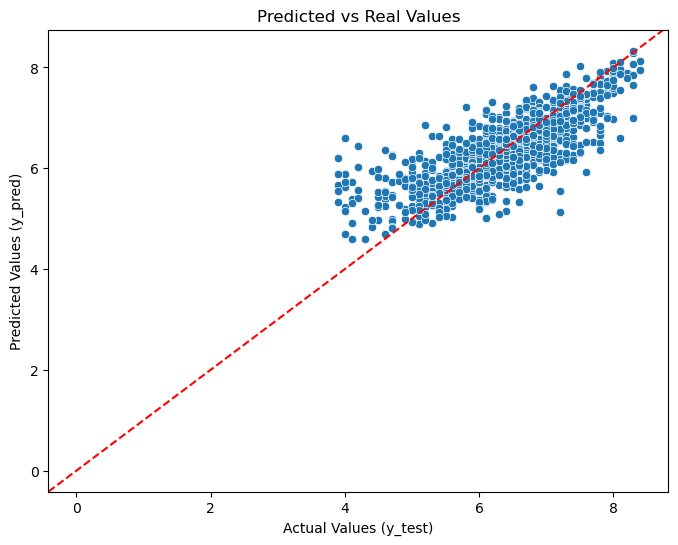

In [188]:

# Create a scatter plot for Predicted vs Real values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Predicted vs Real Values')
plt.axline((0, 0), slope=1, color='r', linestyle='--')  # Line y=x for reference
plt.show()


### Residual Plot

This plot shows the residuals (actual - predicted values) against predicted values. Random distribution around the red horizontal line at zero indicates good model performance

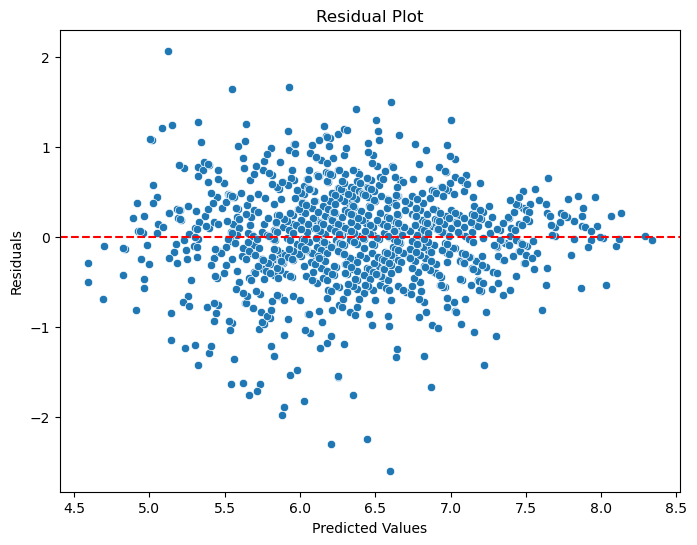

In [189]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


### Distribution of Residuals

This plot displays the distribution of residuals using a histogram with a kernel density estimate (KDE) overlay. The residuals appear to follow a roughly normal distribution, indicating that the model's errors are generally symmetric and centered around zero, which is a desirable trait in regression models.

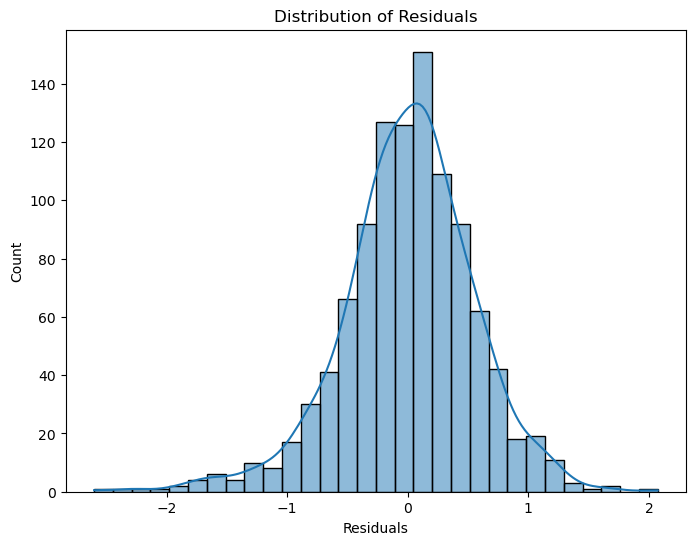

In [190]:
# Plot the distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()


### Normal Q-Q Plot for Residuals

This Q-Q plot compares the residuals to a theoretical normal distribution. The points lie approximately along the reference line, suggesting that the residuals are fairly close to normally distributed. Minor deviations may exist, but overall, the residuals display a reasonable level of normality, which supports model assumptions in regression analysis.

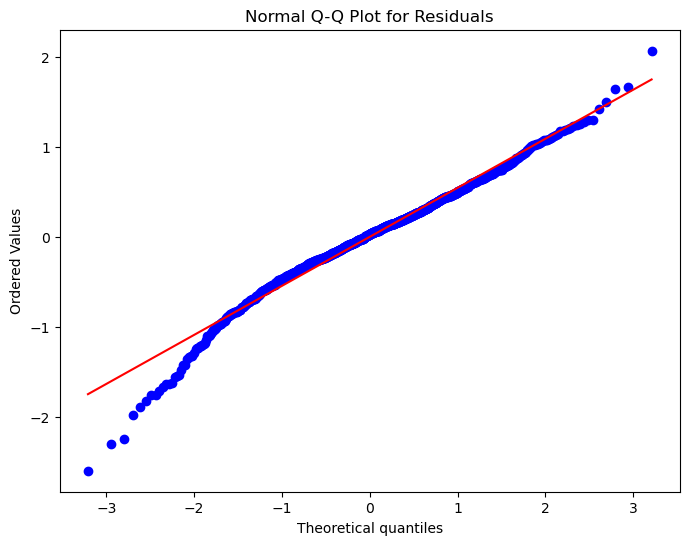

In [191]:

# Generate a Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot for Residuals')
plt.show()

### Conclusion

Our analysis demonstrates that leveraging data such as actors, countries, budget, and box office information can lead to promising predictive results regarding movie success. These features proved to be valuable predictors in building models that can estimate performance outcomes in the film industry. 

For future work, we aim to extend our approach by incorporating directors as an additional feature. We also plan to delve deeper into understanding what influences IMDb scores more significantly — the actors or the directors. Lastly, we will explore enhancing our predictive capabilities to better forecast box office revenue.


In [192]:
awards_df =pd.read_csv(ABS_PATH+'/the_oscar_award.csv')
movies_df = pd.read_csv(ABS_PATH+'/movie_data.csv')
movie_metadata = pd.read_csv('/Users/mohamedhedihidri/Desktop/ada-2024-project-theundocumentedanalysts/data/MovieSummaries/movie.metadata.tsv', sep='\t')

# Display the first few rows of each dataset
print("Movies Dataset:")
print(movies_df.head())

print("\nAwards Dataset:")
print(awards_df.head())

movie_metadata.columns =['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date',
                        'Movie box office revenue','Movie runtime','Movie languages',
                        'Movie countries','Movie genres']
import re
# Normalize movie names by removing special characters and extra spaces

def normalize_name(name):
    return re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z0-9\s]', '', name)).strip().lower()

movies_df['normalized_title'] = movies_df['movie_title'].apply(normalize_name)
movie_metadata['normalized_name'] = movie_metadata['Movie name'].apply(normalize_name)

# Find common movie names in both dataframes after normalization
common_movies_normalized = set(movies_df['normalized_title']).intersection(
    set(movie_metadata['normalized_name'])
)
print(f"Number of common movies after normalization: {len(common_movies_normalized)}")
print("Common movies after normalization:", common_movies_normalized)

# Merge datasets based on normalized names
merged_normalized_df = pd.merge(movies_df, movie_metadata, how='inner', left_on='normalized_title', right_on='normalized_name')

# Remove duplicates from the merged dataframe
merged_normalized_df.drop_duplicates(subset='normalized_title', inplace=True)

# Display the merged dataframe without duplicates
print(f"Number of common movies after removing duplicates: {len(merged_normalized_df)}")
merged_normalized_df.head()

Movies Dataset:
   index      director_name  duration      actor_2_name  \
0      0      James Cameron     178.0  Joel David Moore   
1      1     Gore Verbinski     169.0     Orlando Bloom   
2      2         Sam Mendes     148.0      Rory Kinnear   
3      3  Christopher Nolan     164.0    Christian Bale   
4      4        Doug Walker       NaN        Rob Walker   

                            genres     actor_1_name  \
0  Action|Adventure|Fantasy|Sci-Fi      CCH Pounder   
1         Action|Adventure|Fantasy      Johnny Depp   
2        Action|Adventure|Thriller  Christoph Waltz   
3                  Action|Thriller        Tom Hardy   
4                      Documentary      Doug Walker   

                                         movie_title  num_voted_users  \
0                                            Avatar            886204   
1          Pirates of the Caribbean: At World's End            471220   
2                                           Spectre            275868   
3     

,index,director_name,duration,actor_2_name,genres,actor_1_name,movie_title,num_voted_users,actor_3_name,movie_imdb_link,...,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,normalized_name
0,0,James Cameron,178.0,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,Wes Studi,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,...,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",avatar
3,1,Gore Verbinski,169.0,Orlando Bloom,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,Jack Davenport,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,...,1689394,/m/05nlx4,Pirates of the Caribbean: At World's End,2007-05-19,9.634204e+08,169.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02qvnvs"": ""Swashbuckler films"", ""/m/0hj3n...",pirates of the caribbean at worlds end
4,2,Sam Mendes,148.0,Rory Kinnear,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,Stephanie Sigman,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,...,3015828,/m/08kqhx,Spectre,1977,NaN,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/015w9s"": ""Televisio...",spectre
5,3,Christopher Nolan,164.0,Christian Bale,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,Joseph Gordon-Levitt,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,...,29075630,/m/0bpm4yw,The Dark Knight Rises,2012-07-16,1.078009e+09,165.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",the dark knight rises
6,5,Andrew Stanton,132.0,Samantha Morton,Action|Adventure|Sci-Fi,Daryl Sabara,John Carter,212204,Polly Walker,http://www.imdb.com/title/tt0401729/?ref_=fn_t...,...,982480,/m/03whyr,John Carter,2012-03-08,2.827781e+08,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0cq23f0"": ""Sci-Fi Adventure"", ""/m/06n90"":...",john carter


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mean Absolute Error on test data: 0.3590
Mean Absolute Percentage Error on test data: 0.0539

Best hyperparameters found:
colsample_bytree: 0.8245108790277985
gamma: 0.3854835899772805
learning_rate: 0.10875911927287815
max_depth: 3
n_estimators: 306
reg_alpha: 0.42754101835854963
reg_lambda: 0.02541912674409519
subsample: 0.6431565707973218


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished



Mean CV MAE: 0.3659 ± 0.0121
Cross-validation MAE scores for each fold: [0.36830203 0.35822171 0.35613807 0.35816977 0.3884284 ]


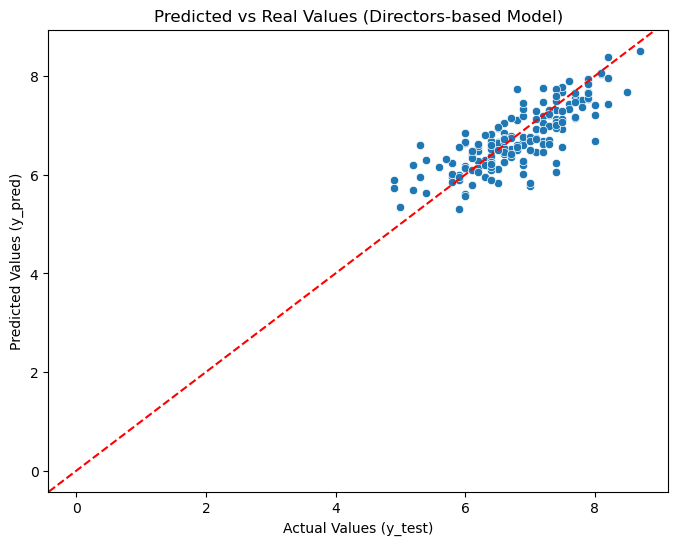

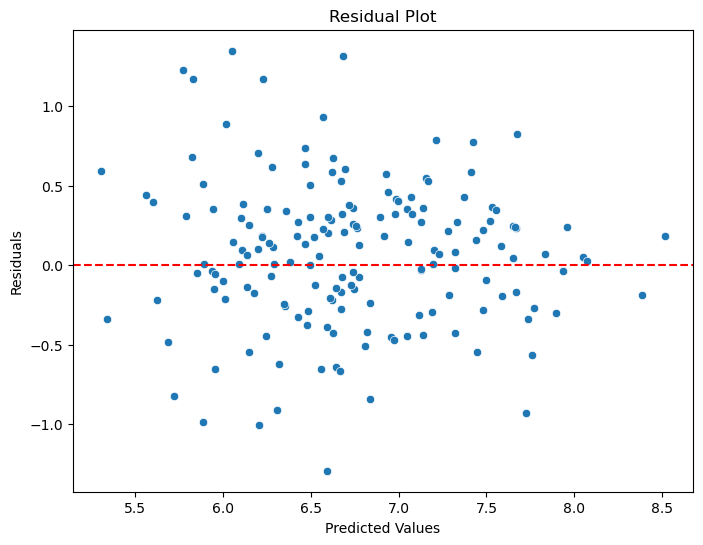

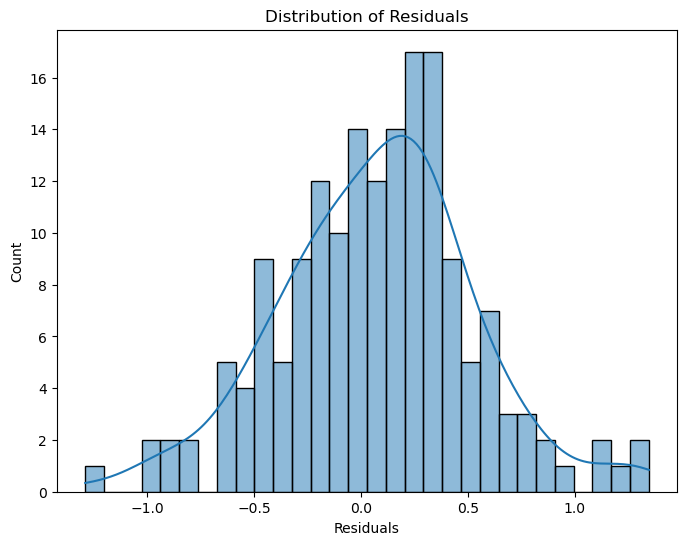

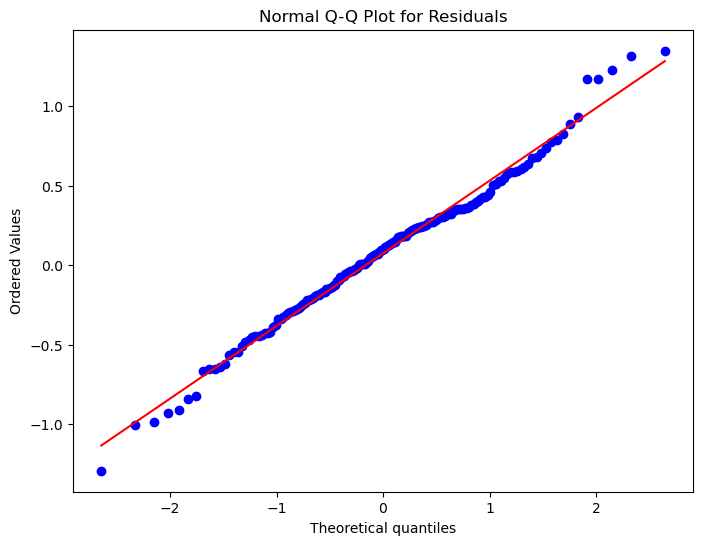

In [197]:
df_directors = merged_movie_character_tmdb.copy()

# Add movie_name column
df_directors['movie_name'] = movie_name_column

# Normalize function for movie titles
def normalize_name(name):
    return re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z0-9\s]', '', str(name))).strip().lower()

# If director_name is not present, merge it from movies_df
if 'director_name' not in df_directors.columns:
    movies_df = pd.read_csv(ABS_PATH+'/movie_data.csv')
    movies_df['normalized_title'] = movies_df['movie_title'].apply(normalize_name)
    df_directors['normalized_title'] = df_directors['movie_name'].apply(normalize_name)
    
    df_directors = pd.merge(df_directors, 
                            movies_df[['normalized_title','director_name']], 
                            on='normalized_title', 
                            how='left')

# Drop rows without a director
df_directors = df_directors.dropna(subset=['director_name'])

# Count how many unique movies each director has
director_movie_counts = df_directors.groupby('director_name')['movie_name'].nunique()

# Identify directors that have at least 5 different movies
directors_with_5_or_more_movies = director_movie_counts[director_movie_counts >= 5].index

# Filter the DataFrame to keep only those directors
df_directors = df_directors[df_directors['director_name'].isin(directors_with_5_or_more_movies)]

# Create dummy variables for the filtered directors
dummy_director_columns = {}
for director in directors_with_5_or_more_movies:
    dummy_column = (df_directors['director_name'] == director).astype(int)
    dummy_director_columns[f'dummy_director_{director}'] = dummy_column

dummy_director_df = pd.DataFrame(dummy_director_columns)
dummy_director_df.reset_index(drop=True, inplace=True)
df_directors.reset_index(drop=True, inplace=True)

# Concatenate director dummy columns
df_directors = pd.concat([df_directors, dummy_director_df], axis=1)

# Remove unnecessary columns
columns_to_drop = ['actor_name','character_name','normalized_title']
for col in columns_to_drop:
    if col in df_directors.columns:
        df_directors = df_directors.drop(col, axis=1)

###################################
# PREPARE DATA FOR MODELING
###################################

# Ensure release_date is handled
if 'movie_release_date_x' in df_directors.columns:
    df_directors['movie_release_date_x'] = pd.to_datetime(df_directors['movie_release_date_x'], errors='coerce')
    df_directors['release_year'] = df_directors['movie_release_date_x'].dt.year
    df_directors = df_directors.drop('movie_release_date_x', axis=1, errors='ignore')

# Remove rows with missing target or insufficient VOTE_COUNT
df_directors = df_directors.dropna(subset=['VOTE_AVERAGE'])
df_directors = df_directors[df_directors['VOTE_COUNT'] >= 5]

# Drop duplicates by movie if needed
if 'movie_name' in df_directors.columns:
    df_directors = df_directors.drop_duplicates(subset='movie_name')
    df_directors = df_directors.drop('movie_name', axis=1, errors='ignore')

# Convert ADULT to binary if present
if 'ADULT' in df_directors.columns:
    df_directors['ADULT'] = df_directors['ADULT'].apply(lambda x: 1 if x == True else 0)

# For a gender column: map 'F' -> 0, 'M' -> 1
if 'gender_column' in df_directors.columns:
    df_directors['gender_column'] = df_directors['gender_column'].map({'F': 0, 'M': 1})

df_directors = df_directors.select_dtypes(include=[np.number])

# Remove columns with zero variance
df_directors = df_directors.loc[:, df_directors.var() != 0]

# Identify non-scalar columns and drop them
non_scalar_columns = []
for col in df_directors.columns:
    if len(df_directors) > 0:
        first_elem = df_directors[col].iloc[0]
        if not np.isscalar(first_elem):
            non_scalar_columns.append(col)

if non_scalar_columns:
    df_directors.drop(non_scalar_columns, axis=1, inplace=True)

# Ensure all features are numeric
df_directors = df_directors.select_dtypes(include=[np.number])

# Fill remaining missing values with mean
df_directors.fillna(df_directors.mean(), inplace=True)

# Outlier removal for the target (VOTE_AVERAGE), if desired
Q1 = df_directors['VOTE_AVERAGE'].quantile(0.25)
Q3 = df_directors['VOTE_AVERAGE'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR
df_directors = df_directors[(df_directors['VOTE_AVERAGE'] >= lower_bound) & (df_directors['VOTE_AVERAGE'] <= upper_bound)]

# Separate features and target
X = df_directors.drop(['VOTE_AVERAGE'], axis=1)
y = df_directors['VOTE_AVERAGE']

# Drop rows where target is missing (if any)
X = X[y.notnull()]
y = y[y.notnull()]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Save X to CSV
X.to_csv(ABS_PATH+'/X_directors.csv', index=False)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

####################################
# MODEL TRAINING AND HYPERPARAM TUNING
####################################

param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_xgb = random_search.best_estimator_

# Evaluate the model
y_pred = best_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Error on test data: {mae:.4f}")
print(f"Mean Absolute Percentage Error on test data: {mape:.4f}")
print("\nBest hyperparameters found:")
for param_name in sorted(random_search.best_params_.keys()):
    print(f"{param_name}: {random_search.best_params_[param_name]}")

# Cross-validation for best model
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    best_xgb,
    X_train,
    y_train,
    cv=cv_strategy,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
)

mean_cv_mae = -np.mean(cv_scores)
std_cv_mae = np.std(cv_scores)
print(f"\nMean CV MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
print("Cross-validation MAE scores for each fold:", -cv_scores)

####################################
# PLOTS (Predicted vs Real, Residuals)
####################################

# Predicted vs Real Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Predicted vs Real Values (Directors-based Model)')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Residual Distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

# Normal Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot for Residuals')
plt.show()


/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_56065/2065832088.py:91: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_movie_character_tmdb[column].fillna(merged_movie_character_tmdb[column].median(), inplace=True)
/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_56065/2065832088.py:169: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_countries_genres = df_countries_genres.applymap(lambda x: tuple(x) if isinstance(x, list) else x)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6125253169822235, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.42114238729749925,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09995082667395314,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=369, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)
Mean Absolute Error on test data: 0.5245
Mean Absolute Percentage Error on test data: 0.0843

Best hyperparameters found:
colsample_bytree: 0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished



Mean CV MAE: 0.5328 ± 0.0202
Cross-validation MAE scores for each fold: [0.53749468 0.55638261 0.53053155 0.54321908 0.49615089]


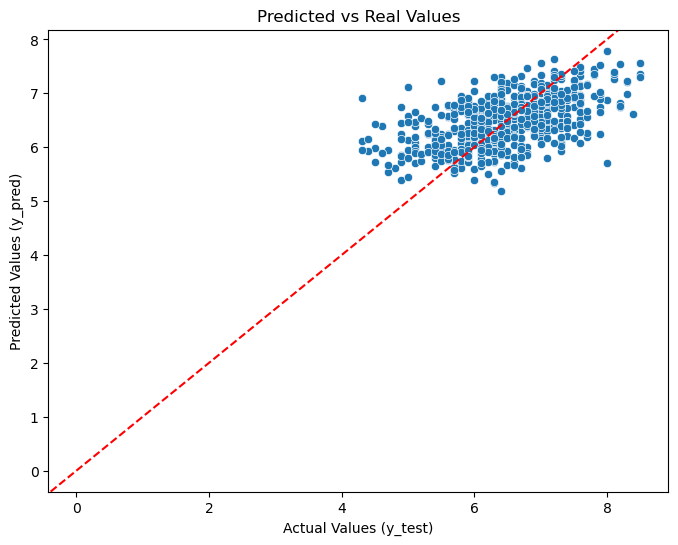

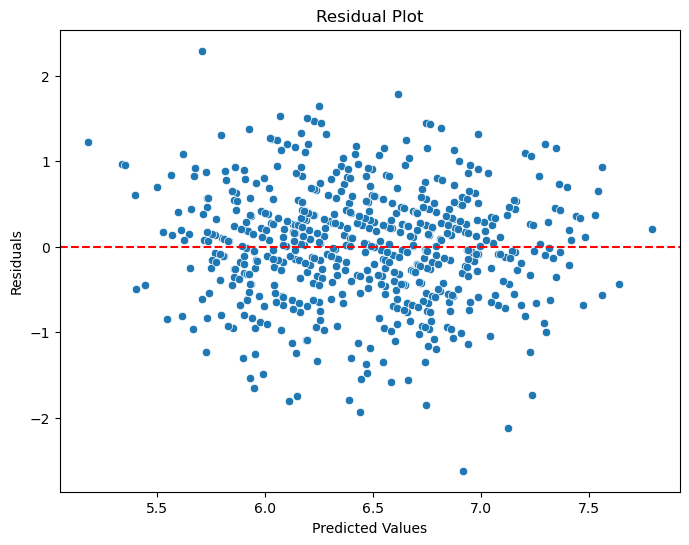

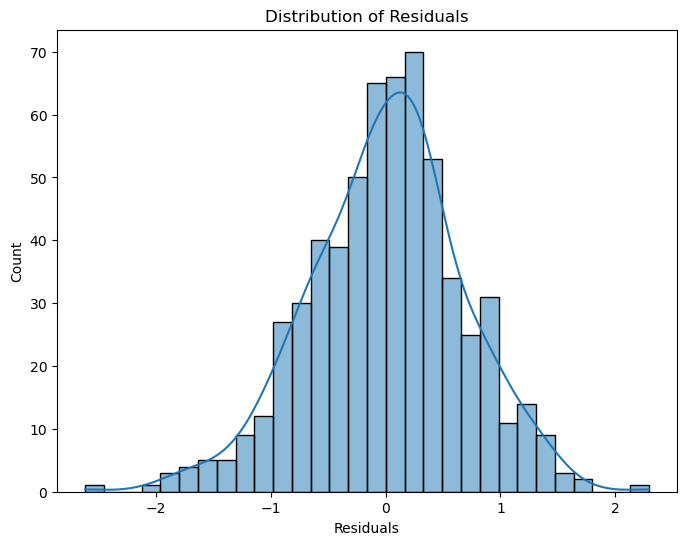

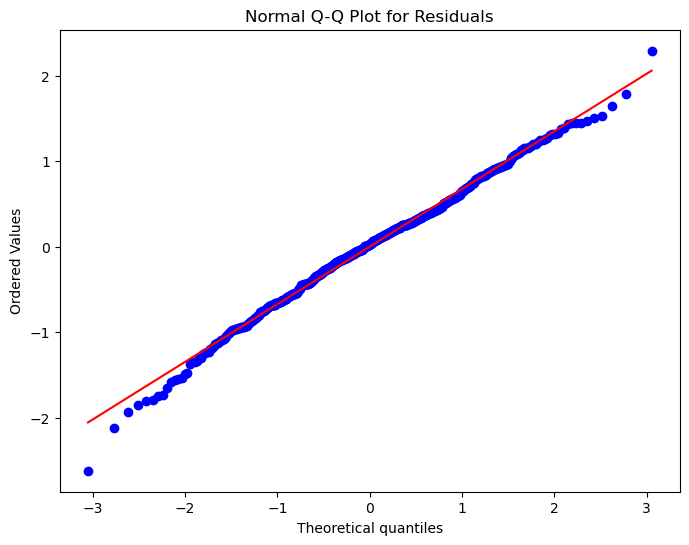

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

# Set your absolute path
ABS_PATH = '/Users/mohamedhedihidri/Desktop/ada-2024-project-theundocumentedanalysts/data'

#-------------------------------------
# LOAD AND MERGE DATASETS
#-------------------------------------

# Load movie and character metadata
movie_metadata = pd.read_csv(os.path.join(ABS_PATH, 'MovieSummaries/movie.metadata.tsv'), 
                             sep='\t', header=None, names=[
                                 'wikipedia_movie_id',
                                 'freebase_movie_id',
                                 'movie_name',
                                 'movie_release_date',
                                 'movie_box_office_revenue',
                                 'movie_runtime',
                                 'movie_languages',
                                 'movie_countries',
                                 'movie_genres'
                             ])

character_metadata = pd.read_csv(os.path.join(ABS_PATH, 'MovieSummaries/character.metadata.tsv'),
                                 sep='\t', header=None, names=[
                                     'wikipedia_movie_id',
                                     'freebase_movie_id',
                                     'movie_release_date_y',
                                     'character_name',
                                     'actor_date_of_birth',
                                     'actor_gender',
                                     'actor_height',
                                     'actor_ethnicity',
                                     'actor_name',
                                     'actor_age_at_movie_release',
                                     'freebase_character_actor_map_id',
                                     'freebase_character_id',
                                     'freebase_actor_id'
                                 ])

# Merge character and movie metadata
merged_movie_character = pd.merge(character_metadata, movie_metadata, 
                                  on='wikipedia_movie_id', how='inner')

# Drop irrelevant ID columns
merged_movie_character = merged_movie_character.drop([
    'freebase_character_actor_map_id',
    'freebase_character_id',
    'freebase_actor_id',
    'freebase_movie_id_x',
    'freebase_movie_id_y'
], axis=1)

# Load TMDb dataset
tmdb = pd.read_excel(os.path.join(ABS_PATH, 'TMDB_dataset/MOVIE.xlsx'))
tmdb = tmdb[tmdb['RELEASE_DATE'] <= '2014-03-28']
tmdb = tmdb.drop(['ID','FILMID','BACKDROP_PATH','HOMEPAGE','IMDB_ID','POSTER_PATH',
                  'ORIGINAL_LANGUAGE','ORIGINAL_TITLE','OVERVIEW','STATUS_','COLLECTIONID'], axis=1)

# Merge with TMDb on movie_name = TITLE
merged_movie_character_tmdb = pd.merge(merged_movie_character, tmdb, 
                                       left_on='movie_name', right_on='TITLE', how='inner')

# Remove actor_date_of_birth, REVENUE, TAGLINE, TITLE
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['actor_date_of_birth','REVENUE','TAGLINE','TITLE'], axis=1)

# Drop rows where BUDGET <= 0
merged_movie_character_tmdb = merged_movie_character_tmdb[merged_movie_character_tmdb['BUDGET'] > 0]

# Convert RELEASE_DATE to datetime and extract year, then drop it
merged_movie_character_tmdb['RELEASE_DATE'] = pd.to_datetime(merged_movie_character_tmdb['RELEASE_DATE'], errors='coerce')
merged_movie_character_tmdb['RELEASE_DATE'] = merged_movie_character_tmdb['RELEASE_DATE'].dt.year

# Drop columns with more than 40% missing values
merged_movie_character_tmdb = merged_movie_character_tmdb.dropna(thresh=0.6*len(merged_movie_character_tmdb), axis=1)

# Fill numeric missing with median
for column in merged_movie_character_tmdb.select_dtypes(include=[np.number]).columns:
    merged_movie_character_tmdb[column].fillna(merged_movie_character_tmdb[column].median(), inplace=True)

#---------------------------
# ACTOR ENCODING (≥5 movies)
#---------------------------
actor_movie_counts = merged_movie_character_tmdb.groupby('actor_name')['movie_name'].nunique()
actors_with_5_or_more_movies = actor_movie_counts[actor_movie_counts >= 5].index

dummy_actor_columns = {}
for actor in actors_with_5_or_more_movies:
    dummy_column = (merged_movie_character_tmdb['actor_name'] == actor).astype(int)
    dummy_actor_columns[f'dummy_actor_{actor}'] = dummy_column
    
dummy_actor_df = pd.DataFrame(dummy_actor_columns)
merged_movie_character_tmdb.reset_index(drop=True, inplace=True)
dummy_actor_df.reset_index(drop=True, inplace=True)
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, dummy_actor_df], axis=1)

#---------------------------
# GENRE, LANGUAGE, COUNTRY ENCODING
#---------------------------
def clean_column(genre_str):
    if pd.isna(genre_str):
        return []
    else:
        pattern = r':\s*["\']([^"\']+)["\']'
        genres = re.findall(pattern, genre_str)
        return genres

# Genres
merged_movie_character_tmdb['genre_list'] = merged_movie_character_tmdb['movie_genres'].apply(clean_column)
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(merged_movie_character_tmdb['genre_list']),
                             columns=mlb.classes_, index=merged_movie_character_tmdb.index)
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, genre_dummies], axis=1)

# Languages
merged_movie_character_tmdb['movie_languages'] = merged_movie_character_tmdb['movie_languages'].apply(clean_column)
lang_dummies = pd.DataFrame(mlb.fit_transform(merged_movie_character_tmdb['movie_languages']),
                            columns=mlb.classes_, index=merged_movie_character_tmdb.index)
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, lang_dummies], axis=1)

# Countries
merged_movie_character_tmdb['movie_countries'] = merged_movie_character_tmdb['movie_countries'].apply(clean_column)
country_dummies = pd.DataFrame(mlb.fit_transform(merged_movie_character_tmdb['movie_countries']),
                               columns=mlb.classes_, index=merged_movie_character_tmdb.index)
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, country_dummies], axis=1)

merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['movie_genres','genre_list','movie_languages','movie_countries','actor_name','character_name'], axis=1)

# Drop rows with NaN and VOTE_COUNT < 5
merged_movie_character_tmdb = merged_movie_character_tmdb.dropna()
merged_movie_character_tmdb = merged_movie_character_tmdb[merged_movie_character_tmdb['VOTE_COUNT'] >= 5]

# Drop duplicates by movie_name
merged_movie_character_tmdb = merged_movie_character_tmdb.drop_duplicates(subset=['movie_name'])

# Drop RELEASE_DATE and store movie_name separately
if 'RELEASE_DATE' in merged_movie_character_tmdb.columns:
    merged_movie_character_tmdb = merged_movie_character_tmdb.drop('RELEASE_DATE', axis=1)

movie_name_column = merged_movie_character_tmdb['movie_name']
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['movie_name'], axis=1)

# Convert ADULT to binary
if 'ADULT' in merged_movie_character_tmdb.columns:
    merged_movie_character_tmdb['ADULT'] = merged_movie_character_tmdb['ADULT'].apply(lambda x: 1 if x == True else 0)

# Before removing zero variance columns, ensure all are numeric
merged_movie_character_tmdb = merged_movie_character_tmdb.select_dtypes(include=[np.number])

# Remove columns with zero variance
merged_movie_character_tmdb = merged_movie_character_tmdb.loc[:, merged_movie_character_tmdb.var() != 0]

# Copy for df_countries_genres if needed
df_countries_genres = merged_movie_character_tmdb.copy()

# Convert any remaining lists to tuples if needed (likely unnecessary now)
df_countries_genres = df_countries_genres.applymap(lambda x: tuple(x) if isinstance(x, list) else x)

# Remove columns with only one unique value
df_countries_genres = df_countries_genres.loc[:, df_countries_genres.nunique() > 1]

# Save df_countries_genres if needed
df_countries_genres.to_csv(os.path.join(ABS_PATH, 'df_countries_genres.csv'), index=False)

#-------------------------------------
# DIRECTOR ENCODING (≥5 movies)
#-------------------------------------
movies_df = pd.read_csv(os.path.join(ABS_PATH, 'movie_data.csv'))

def normalize_name(title):
    return re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z0-9\s]', '', str(title))).strip().lower()

movies_df['normalized_title'] = movies_df['movie_title'].apply(normalize_name)

df_directors = merged_movie_character_tmdb.copy()
df_directors['movie_name'] = movie_name_column
df_directors['normalized_title'] = df_directors['movie_name'].apply(normalize_name)

if 'director_name' not in df_directors.columns:
    df_directors = pd.merge(df_directors, movies_df[['normalized_title','director_name']],
                            on='normalized_title', how='left')

df_directors = df_directors.dropna(subset=['director_name'])

# Filter directors with ≥5 movies
director_movie_counts = df_directors.groupby('director_name')['movie_name'].nunique()
directors_with_5_or_more_movies = director_movie_counts[director_movie_counts >= 5].index

dummy_director_columns = {}
for director in directors_with_5_or_more_movies:
    dummy_column = (df_directors['director_name'] == director).astype(int)
    dummy_director_columns[f'dummy_director_{director}'] = dummy_column

dummy_director_df = pd.DataFrame(dummy_director_columns)
dummy_director_df.reset_index(drop=True, inplace=True)
df_directors.reset_index(drop=True, inplace=True)
df_directors = pd.concat([df_directors, dummy_director_df], axis=1)

# Drop unnecessary columns
cols_to_drop = ['actor_name','character_name','normalized_title']
for c in cols_to_drop:
    if c in df_directors.columns:
        df_directors = df_directors.drop(c, axis=1)

# Remove rows with missing VOTE_AVERAGE or insufficient VOTE_COUNT
df_directors = df_directors.dropna(subset=['VOTE_AVERAGE'])
df_directors = df_directors[df_directors['VOTE_COUNT'] >= 5]

# Drop duplicates by movie_name
if 'movie_name' in df_directors.columns:
    df_directors = df_directors.drop_duplicates(subset='movie_name')
    df_directors = df_directors.drop('movie_name', axis=1, errors='ignore')

# Convert ADULT to binary if present
if 'ADULT' in df_directors.columns:
    df_directors['ADULT'] = df_directors['ADULT'].apply(lambda x: 1 if x == True else 0)

df_directors = df_directors.select_dtypes(include=[np.number])
df_directors = df_directors.loc[:, df_directors.var() != 0]

# Drop non-scalar columns if any (likely none at this point)
non_scalar_columns = []
for col in df_directors.columns:
    if len(df_directors) > 0:
        first_elem = df_directors[col].iloc[0]
        if not np.isscalar(first_elem):
            non_scalar_columns.append(col)

if non_scalar_columns:
    df_directors.drop(non_scalar_columns, axis=1, inplace=True)

df_directors = df_directors.select_dtypes(include=[np.number])
df_directors.fillna(df_directors.mean(), inplace=True)
#remove columns wikipedia_movie_id actor_age_at_movie_release
df_directors = df_directors.drop(['wikipedia_movie_id','actor_age_at_movie_release','movie_box_office_revenue'], axis=1)
# Outlier removal on VOTE_AVERAGE
Q1 = df_directors['VOTE_AVERAGE'].quantile(0.25)
Q3 = df_directors['VOTE_AVERAGE'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR
df_directors = df_directors[(df_directors['VOTE_AVERAGE'] >= lower_bound) & (df_directors['VOTE_AVERAGE'] <= upper_bound)]
#remove VOTE_COUNT and runtime and Popularity columns
df_directors = df_directors.drop(['VOTE_COUNT','RUNTIME','POPULARITY'], axis=1)
# Separate features and target
X = df_directors.drop(['VOTE_AVERAGE'], axis=1)

y = df_directors['VOTE_AVERAGE']

X = X[y.notnull()]
y = y[y.notnull()]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_xgb = random_search.best_estimator_
print(best_xgb)

# Evaluate
y_pred = best_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Error on test data: {mae:.4f}")
print(f"Mean Absolute Percentage Error on test data: {mape:.4f}")

print("\nBest hyperparameters found:")
for param_name in sorted(random_search.best_params_.keys()):
    print(f"{param_name}: {random_search.best_params_[param_name]}")

# Cross-validation with best model
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=cv_strategy,
                            scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

mean_cv_mae = -np.mean(cv_scores)
std_cv_mae = np.std(cv_scores)

print(f"\nMean CV MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
print("Cross-validation MAE scores for each fold:", -cv_scores)

#---------------------------
# PLOTS
#---------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Predicted vs Real Values')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

plt.figure(figsize=(8,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot for Residuals')
plt.show()

# Conclusion:
# The code now ensures that only numeric columns are used before computing variance,
# preventing the "could not convert string to float" error.


In [2]:
import joblib
import json
import pickle

with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)
print(best_xgb)
#save feature_columns in pkl file
with open('feature_columns.json', 'w') as f:
    json.dump(X.columns.tolist(), f)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6125253169822235, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.42114238729749925,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09995082667395314,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=369, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)


In [17]:
best_xgb = None  # Replace with your trained model
feature_columns = []  # Replace with the actual feature columns from your model training


with open('best_xgb_model.pkl', 'rb') as f:
   best_xgb = pickle.load(f)
with open('feature_columns.json', 'rb') as f:
    feature_columns = json.load(f)

In [10]:
import pickle
import pandas as pd
import numpy as np

# Load the model
with open('best_xgb_model.pkl', 'rb') as f:
    best_xgb = pickle.load(f)

# Load the feature columns
with open('feature_columns.json', 'r') as f:
    feature_columns = json.load(f)

# Create base input with all features initialized to 0
test_input = pd.DataFrame(columns=feature_columns, data=np.zeros((2, len(feature_columns))))

# Set specific values for the input
test_input['movie_runtime'] = [90, 120]
test_input['BUDGET'] = [1000000, 5000000]
test_input['dummy_actor_Actor1'] = [1, 0]
test_input['dummy_director_Director1'] = [0, 1]

# Ensure column order matches the training feature columns
test_input = test_input[feature_columns]

# Make prediction
prediction = best_xgb.predict(test_input)
print(prediction)


[6.94505 6.94505]


In [12]:
# Training feature columns
print("Training Features:", feature_columns)

# Input DataFrame columns
print("Input DataFrame Columns:", test_input.columns)


Training Features: ['movie_runtime', 'BUDGET', 'dummy_actor_Aaron Eckhart', 'dummy_actor_Aaron Johnson', 'dummy_actor_Aaron Paul', 'dummy_actor_Abigail Breslin', 'dummy_actor_Adam Sandler', 'dummy_actor_Adam Scott', 'dummy_actor_Adam West', 'dummy_actor_Adewale Akinnuoye-Agbaje', 'dummy_actor_Adolphe Menjou', 'dummy_actor_Adrian Grenier', 'dummy_actor_Adrien Brody', 'dummy_actor_Agnes Bruckner', 'dummy_actor_Aidan Devine', 'dummy_actor_Al Pacino', 'dummy_actor_Alan Alda', 'dummy_actor_Alan Cumming', 'dummy_actor_Alan Napier', 'dummy_actor_Alan Oppenheimer', 'dummy_actor_Alan Thicke', 'dummy_actor_Alanna Ubach', 'dummy_actor_Albert Salmi', 'dummy_actor_Alec Baldwin', 'dummy_actor_Alex Hyde-White', 'dummy_actor_Alex McArthur', 'dummy_actor_Alexa Nikolas', 'dummy_actor_Alexander Gould', 'dummy_actor_Alexander Siddig', 'dummy_actor_Alexander Skarsgård', 'dummy_actor_Alexis Bledel', 'dummy_actor_Alfonso Arau', 'dummy_actor_Alfre Woodard', 'dummy_actor_Alfred Molina', 'dummy_actor_Ali Larter

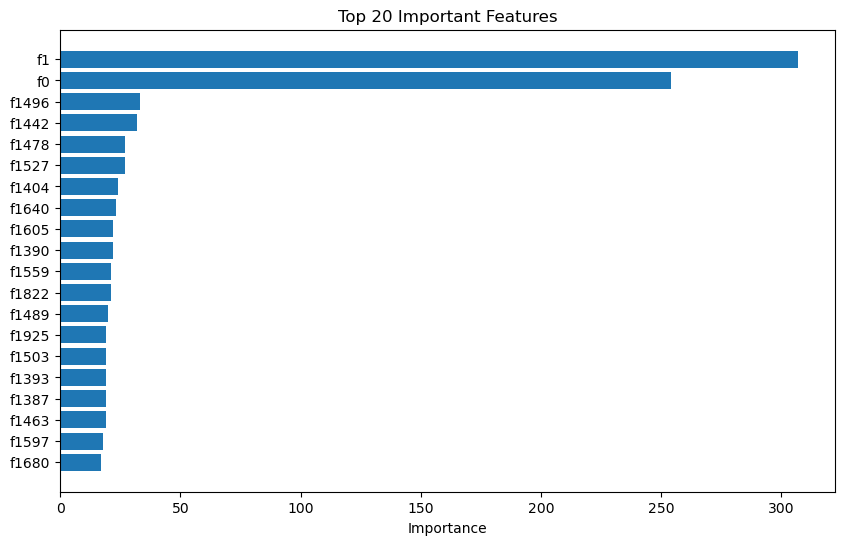

In [24]:
import matplotlib.pyplot as plt

# Get feature importance
importance = best_xgb.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({'Feature': list(importance.keys()), 'Importance': list(importance.values())})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot top 20 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Top 20 Important Features")
plt.gca().invert_yaxis()
plt.show()


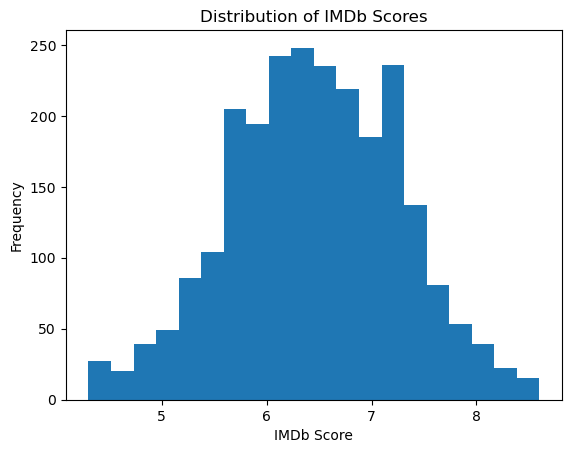

In [26]:
import matplotlib.pyplot as plt

plt.hist(y_train, bins=20)
plt.title("Distribution of IMDb Scores")
plt.xlabel("IMDb Score")
plt.ylabel("Frequency")
plt.show()
